# Discord Data Analyzer

This is a tool that will analyze your discord data much deeper than standard
tools, primarily through using ML to categorize all of your messages.

## How to use

### Getting Your Discord Data
1. Go on discord -> User Settings -> Privacy & Security -> "Request all of my Data"
2. Discord will eventually send you an email with a link that will let you download your "package.zip". It contains all of your discord data and all the messages you have ever sent.

### Prepare Google Colab

1. In the toolbar at the top of this page, click on the Runtime drop down menu
2. "Change Runtime Type"
3. Select "GPU"

### Upload Your Discord Data To This Notebook
1. Go to the "Files" tab on the left of this page.

> 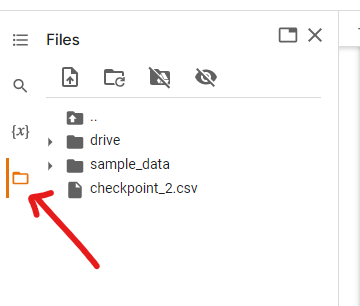
2. Upload your "package.zip" file

### Run this notebook
1. In the toolbar at the top of this page, click on the Runtime drop down menu
2. "Run all"

OR press `CTRL + F9`

In [1]:
%pip install -q wordcloud
%pip install -q torch transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# @title If you get an error here, change your runtime type to "GPU"
import torch;
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert(device.type == 'cuda')

In [3]:
# @title Timezone
import pandas as pd
TimeZone = "US/Eastern" #@param {type:"string"}
date = pd.Timestamp.now(tz=TimeZone)
print("See if your timezone is correct: ", date)

See if your timezone is correct:  2023-03-27 16:25:24.514901-04:00


In [4]:
#@title (Optionally) Get Data From Google Drive

GetPackageFromDrive = "no" #@param ["yes", "no"]
GoogleDriveLocation = "/content/drive/MyDrive/package.zip" #@param {type:"string"}

if GetPackageFromDrive == "yes" and GoogleDriveLocation is not None:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  import shutil
  shutil.copyfile(GoogleDriveLocation, "package.zip")

In [5]:
# @title Unzip Package
import os
import zipfile

if not os.path.isdir("package"):
  assert os.path.isfile("package.zip")
  with zipfile.ZipFile("package.zip", 'r') as zip_ref:
      zip_ref.extractall("package")
assert os.path.isdir("package")

# Initialization

In [6]:
# @title Common Data Visualization Util

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_context("talk")

def keyword_match_wrapper(keyword: str) -> str:
  return f'(?<![a-zA-Z0-9]){keyword}(?![a-zA-Z0-9])'

def group_and_transform_data(df, group_by, transformer):
  buckets = df.groupby(group_by)
  buckets = {b[0]: transformer(b[1]) for b in buckets}
  bucketed_df = pd.DataFrame.from_dict(buckets, orient='index')
  return bucketed_df

import matplotlib.ticker
import calendar

day_of_week_formatter = matplotlib.ticker.FuncFormatter(lambda x, pos: calendar.day_name[int(x) - 1])
month_name_formatter = lambda base: matplotlib.ticker.FuncFormatter(lambda x, pos: calendar.month_name[int(x) - base])

In [7]:
# @title Load Data

import json

channel_name_map = None
with open("package/messages/index.json") as index:
  channel_name_map = json.load(index)

import os
import pandas as pd

df_acc = []
subdirs = next(os.walk('package/messages'))[1]
for subdir in subdirs:
  df = pd.read_csv(os.path.join("package/messages", subdir, "messages.csv"))
  df["Channel"] = channel_name_map.get(f'c{subdir}', None)
  df_acc.append(df)
df = pd.concat(df_acc)
df = df[['Timestamp', 'Contents', 'Channel']]
assert 'Timestamp' in df, 'Contents' in df
print(f'{len(df.index)} Messages loaded')

287189 Messages loaded


In [8]:
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.tz_convert(TimeZone)

In [9]:
# Record information about the pre-cleaned data, mostly for Basic Information Visualization

import pandas as pd

unprocessed_df_info = pd.DataFrame({
    'Timestamp': df['Timestamp'],
    'ContentsLength': df['Contents'].str.len()
})

In [10]:
# @title Clean Data

import datetime

df.reset_index(inplace=True)

df.dropna(subset=["Contents"], inplace=True)

contents = df['Contents']
contents = contents.str.strip()

# emotes eg <:moon2S:901721403550728193> | <a:moon2S:901721403550728193> (a means animated) | :moon2S: -> moon2S
contents = contents.str.replace(r'(<a?)?:([\w\d]+):(\d{18}>)?', r'\2', regex=True)
# user tag
contents = contents.str.replace('<@[!&]?[0-9]+>', '[Name]', regex=True)

df['Contents'] = contents

In [11]:
# @title Filter Data

def drop(df, mask) -> int:
  original_df_size = len(df.index)
  df.drop(df[mask].index, inplace=True)
  dropped_rows = original_df_size - len(df.index)
  return dropped_rows

def drop_by_regex(df, regex) -> int:
  if isinstance(regex, list) or isinstance(regex, tuple) or isinstance(regex, set):
    regex = '|'.join(regex)
  match_mask = df["Contents"].str.match(regex)
  return drop(df, match_mask)

patterns_to_remove = dict(
  URL = r"^(https?:\/\/(?:www\.)?)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)$",
  EMAIL = r"^[\w\-\.]+@([\w\-]+\.)+[\w\-]{2,4}$",

  DISCORD_COMMAND = r"^[!$%].+",
  CODE_BLOCK = r"```(.|\n)*```",

  OK = r"^(?i)(ok(ay|ie|ie dokie)?)$"
)

df.dropna(subset=["Contents"], inplace=True)

for name, pattern in patterns_to_remove.items():
  dropped = drop_by_regex(df, pattern)
  print(dropped, name, "removed")

print(drop(df, df['Contents'].str.len() <= 2), "troglodyte grunts removed")

7739 URL removed
0 EMAIL removed
27695 DISCORD_COMMAND removed
70 CODE_BLOCK removed
1638 OK removed
19329 troglodyte grunts removed


# Basic Information Visualization

In [12]:
import requests
import numpy as np

PROFANE_WORDS_URL = "https://raw.githubusercontent.com/zacanger/profane-words/master/words.json"

profane_words = requests.get(PROFANE_WORDS_URL).json()
profane_words_regex = f'(?<![a-zA-Z0-9])({"|".join(profane_words)})(?![a-zA-Z0-9])'

In [ ]:
# @title Wordclouds

import matplotlib.pyplot as plt

COMMON_WORDS_URL = "https://raw.githubusercontent.com/first20hours/google-10000-english/master/google-10000-english-no-swears.txt"

def show_wordcloud(wordcloud):
  plt.figure(figsize=(10,5))
  plt.imshow(wordcloud, interpolation='spline36')
  plt.axis("off")
  plt.show()

def make_wordcloud(df):
  from wordcloud import WordCloud
  from wordcloud import STOPWORDS

  # default stopwords
  text = " ".join(i for i in df["Contents"])
  show_wordcloud(WordCloud(width=1800, height=800, background_color="white").generate(text))
  
  # without most common words
  import requests
  response = requests.get(COMMON_WORDS_URL)
  google_common_words = {w.decode() for w in response.iter_lines()}.union(STOPWORDS)
  show_wordcloud(WordCloud(width=1800, height=800, stopwords=google_common_words, background_color="white").generate(text))

  # without swears
  response = requests.get(COMMON_WORDS_URL)
  omega_stopwords_set = set(profane_words).union(google_common_words)
  show_wordcloud(WordCloud(width=1800, height=800, stopwords=omega_stopwords_set, background_color="white").generate(text))

make_wordcloud(df)

In [14]:
# @title Most Used Profanities

profane_words_matches = df['Contents'].str.extract(profane_words_regex)
profane_words_matches = profane_words_matches[profane_words_matches.values != np.NaN].value_counts()

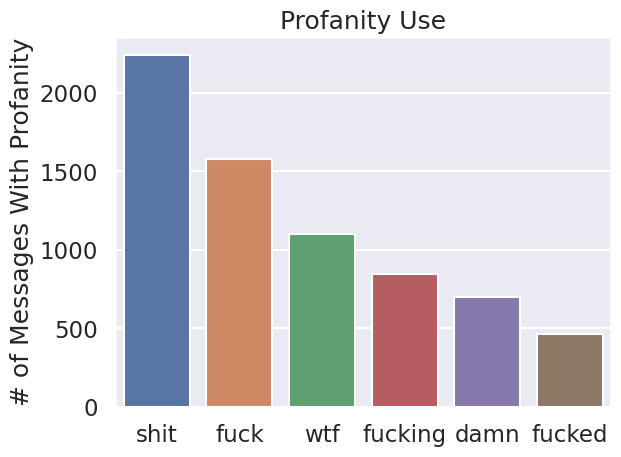

In [15]:
ProfanitiesPage = 0 # @param {type:"integer"}
profanities_page_size = 6

pwm_top = profane_words_matches[ProfanitiesPage * profanities_page_size : (ProfanitiesPage + 1) * profanities_page_size]
pwm_labels = [e[0] for e in pwm_top.index.to_list()]
ax = sns.barplot(x=pwm_labels, y=pwm_top.values);
ax.set(title="Profanity Use", ylabel="# of Messages With Profanity");

## Number of Messages Sent Over Time

In [16]:
total_messages_sent = len(unprocessed_df_info.index)
print(f'{total_messages_sent} total messages sent')
total_characters_sent = int(unprocessed_df_info["ContentsLength"].sum())
print(f'{total_characters_sent} total characters sent')
print(f'{total_characters_sent // total_messages_sent} characters per message on average')

287189 total messages sent
7113841 total characters sent
24 characters per message on average


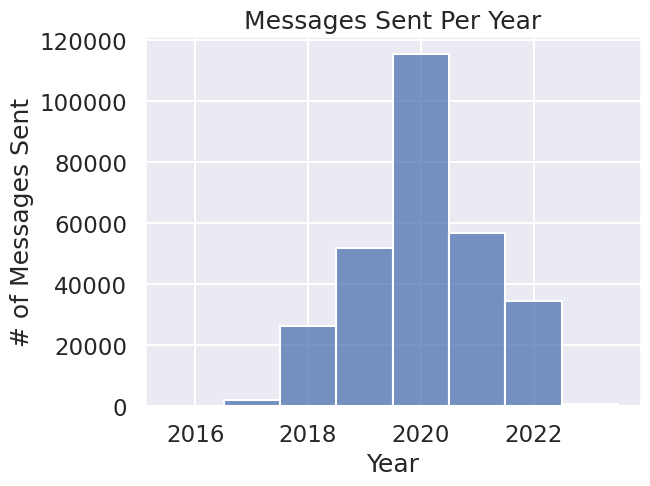

In [17]:
ax = sns.histplot(data=unprocessed_df_info['Timestamp'].dt.year, discrete=True)
ax.set(title="Messages Sent Per Year", xlabel="Year", ylabel="# of Messages Sent");

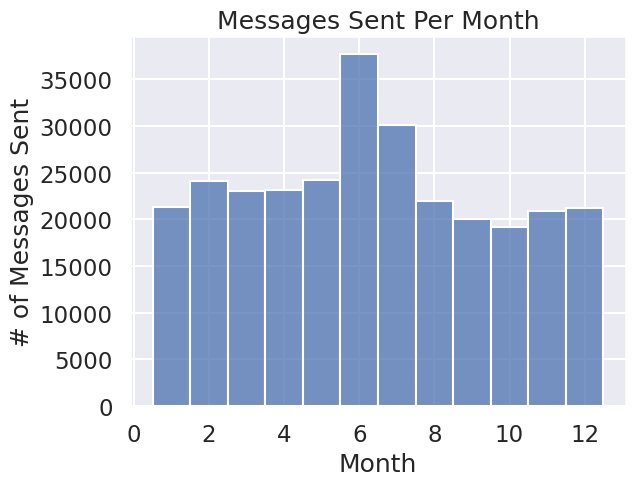

In [18]:
ax = sns.histplot(data=unprocessed_df_info['Timestamp'].dt.month, discrete=True)
ax.set(title="Messages Sent Per Month", xlabel="Month", ylabel="# of Messages Sent");
#ax.xaxis.set_major_formatter(month_name_formatter(0))
#ax.set(xlim=(1, 12));

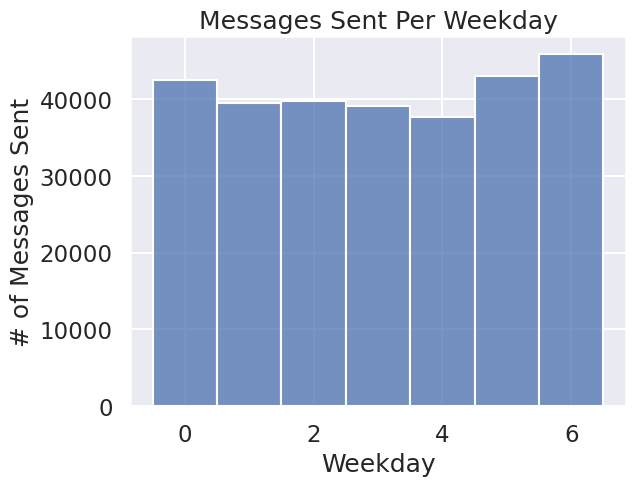

In [19]:
count_by_week_ax = sns.histplot(data=unprocessed_df_info['Timestamp'].dt.weekday, discrete=True)

count_by_week_ax.set(title="Messages Sent Per Weekday", xlabel="Weekday", ylabel="# of Messages Sent");
#count_by_week_ax.xaxis.set_major_formatter(day_of_week_formatter);
#for label in count_by_week_ax.get_xticklabels(which='major'):
    #label.set(rotation=30, horizontalalignment='right')

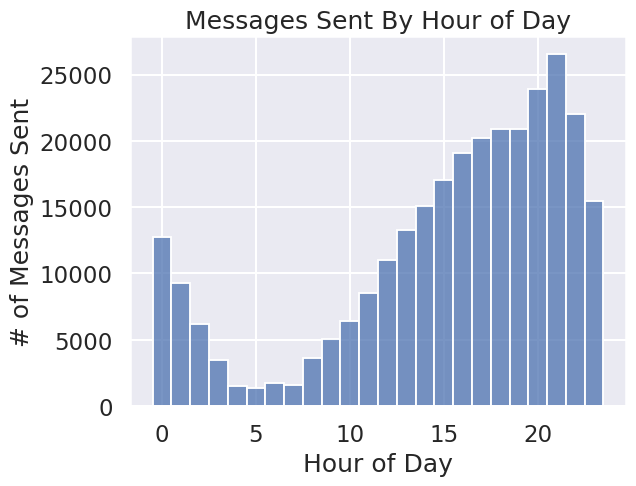

In [20]:
ax = sns.histplot(data=unprocessed_df_info['Timestamp'].dt.hour, discrete=True)
ax.set(title="Messages Sent By Hour of Day", xlabel="Hour of Day", ylabel="# of Messages Sent");

### Message Activity Heatmap
Notice the dark streak in the heatmap. This shows how your sleep schedule changes throughout the year.

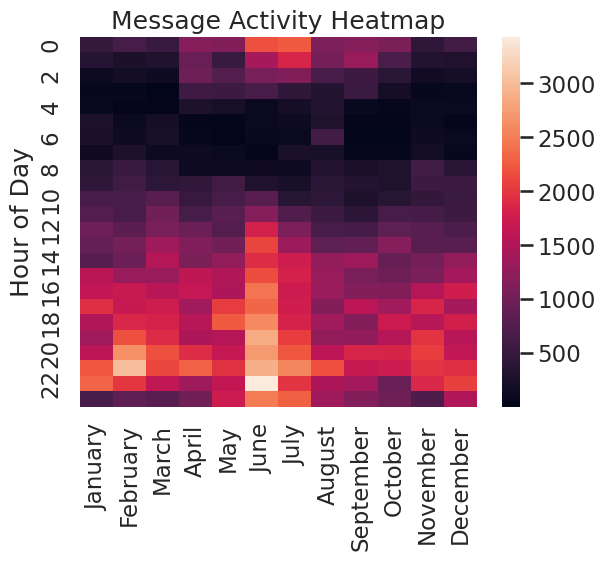

In [21]:
import pandas as pd

month_vs_hour_count = pd.DataFrame({
    calendar.month_name[m]: unprocessed_df_info[unprocessed_df_info['Timestamp'].dt.month == m]['Timestamp'].dt.hour.value_counts() for m in range(1, 13)
})
ax = sns.heatmap(data=month_vs_hour_count);
ax.set(title="Message Activity Heatmap", ylabel="Hour of Day");

## Mentions Over Time

Note that this does not include @ing users

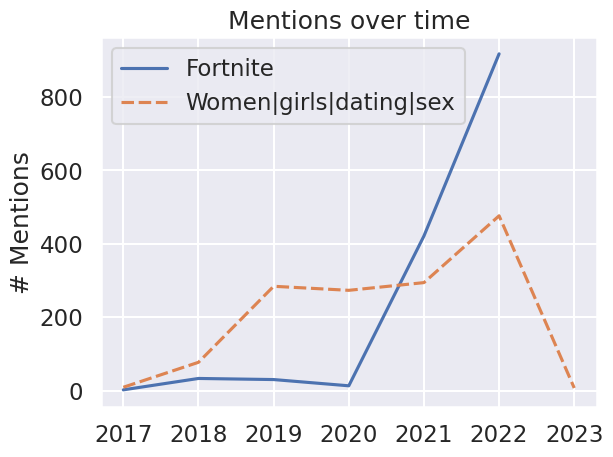

In [22]:
CommaSeparatedKeywords = "Fortnite, Women|girls|dating|sex" #@param {type:"string"}

keywords = [k.strip() for k in CommaSeparatedKeywords.split(r",")]

def get_mentions_timeseries(df, keyword):
  keyword = keyword_match_wrapper(keyword)
  filtered_rows = df[df['Contents'].str.contains(keyword, case=False)]
  return group_and_transform_data(filtered_rows, pd.Series(filtered_rows['Timestamp'].dt.year), lambda df: len(df.index))

res = {keyword: get_mentions_timeseries(df, keyword)[0] for keyword in keywords}
res = pd.concat(res.values(), keys=keywords, axis=1)
res.sort_index(inplace=True)
ax = sns.lineplot(res)
ax.set(title="Mentions over time", ylabel="# Mentions");

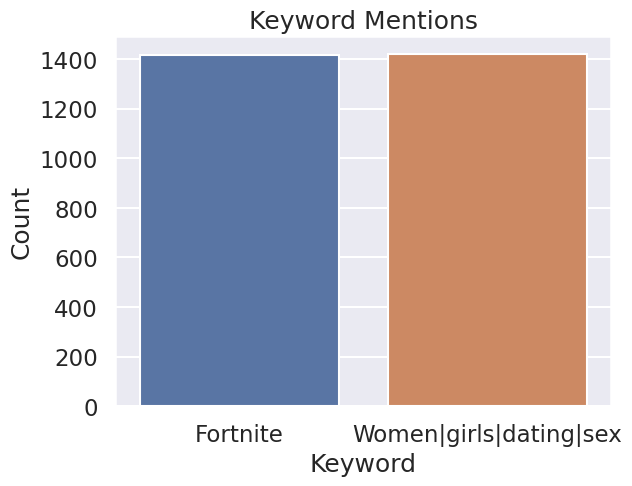

In [23]:
keyword_occurence_count = pd.DataFrame({"Keyword": keywords})
count_mentions = lambda keyword: df['Contents'].str.contains(keyword_match_wrapper(keyword), case=False).sum()
keyword_occurence_count['Count'] = keyword_occurence_count['Keyword'].map(count_mentions)
ax = sns.barplot(keyword_occurence_count, x='Keyword', y='Count')
ax.set(title="Keyword Mentions");

In [41]:
emojis = {
    "🙂": ":[\\s\\-]?)😀|😃|😄|😆|🙂",
    "": "",
    "😩": "😩"
}
emoji_usage = {k: get_mentions_timeseries(df, v)[0] for k, v in emojis }
res = pd.concat(emoji_usage.values(), keys=keywords, axis=1)
res.sort_index(inplace=True)
ax = sns.lineplot(res)
ax.set(title="Mentions over time", ylabel="# Mentions");

ValueError: not enough values to unpack (expected 2, got 1)

## Message Lengths

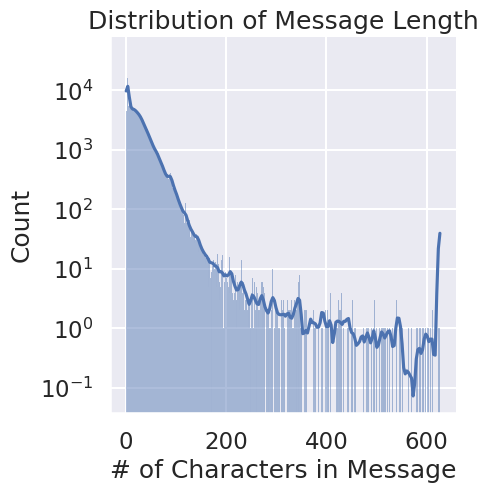

In [24]:
import numpy as np

content_lengths = unprocessed_df_info['ContentsLength'].copy()
cutoff = content_lengths.quantile(.999)
content_lengths[content_lengths >= cutoff] = cutoff
ax = sns.displot(data=content_lengths, binwidth=1, log_scale=(False, True), kde=True)
ax.set(title="Distribution of Message Length", xlabel="# of Characters in Message");

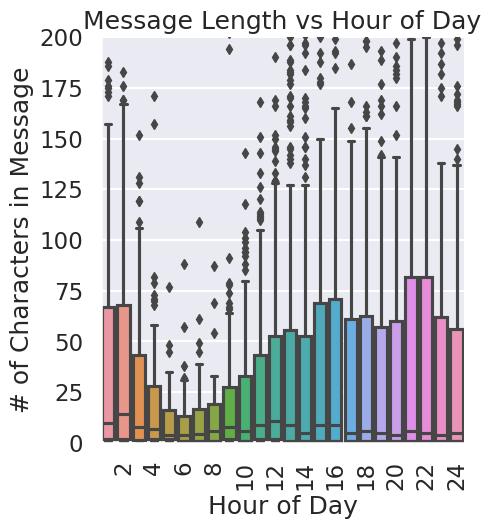

In [25]:
import pandas as pd

hour_vs_message_length = {
    h + 1: unprocessed_df_info[unprocessed_df_info['Timestamp'].dt.hour == h]['ContentsLength'].value_counts() for h in range(0, 24)
}
hour_vs_message_length = pd.DataFrame(hour_vs_message_length)
fg = sns.catplot(data=hour_vs_message_length, kind="box");
fg.set(title="Message Length vs Hour of Day", xlabel="Hour of Day", ylabel="# of Characters in Message", ylim=(0, 200));
for axes in fg.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
    plt.setp(fg.ax.get_xticklabels()[::2], visible=False)

# GoEmotions Inference

This uses a machine learning model to label each of your messages as angry, sad, happy, etc.

This will take a long time. It takes about 24 minutes for my 280,000 messages.
Be patient :)

In [26]:
from transformers import pipeline

emotion = pipeline('sentiment-analysis', model='bhadresh-savani/bert-base-go-emotion', device=0)
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512 // 4}

emotion_labels = emotion(df['Contents'].to_list(), **tokenizer_kwargs)
df['Emotion'] = [v.get('label') for v in emotion_labels]

# GoEmotions Data Visualization

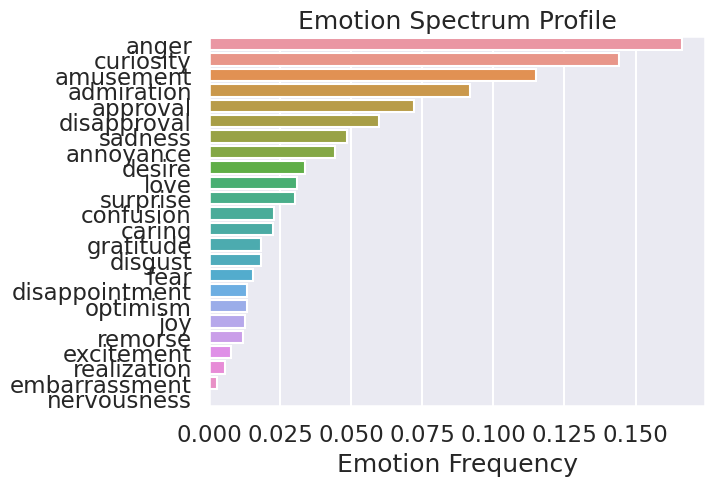

In [27]:
# @title Overall Emotion Profile
emotion_messages = df['Emotion'][df['Emotion'] != 'neutral']
data = emotion_messages.value_counts()
data = data / data.sum()
ax = sns.barplot(x=data, y=data.index)
ax.set(xlabel='Emotion Frequency', title='Emotion Spectrum Profile');

In [ ]:
# @title Emotion Wordclouds
# use one of the emotions above
wordcloud_emotion_selection = "anger" #@param {type:"string"}
wordcloud_emotion_selection = wordcloud_emotion_selection.strip().lower()
make_wordcloud(df[df['Emotion'] == wordcloud_emotion_selection])

In [40]:
# @title Emotional Messages
# use one of the emotions above
message_filter_emotion_selection = "anger" #@param {type:"string"}
message_filter_emotion_selection = wordcloud_emotion_selection.strip().lower()
MessageEmotionFilterPage = 100 # @param {type:"integer"}
message_filter_page_size = 10

df[df['Emotion'].str.match(message_filter_emotion_selection)][MessageEmotionFilterPage*message_filter_page_size:(MessageEmotionFilterPage + 1)*message_filter_page_size]

,index,Timestamp,Contents,Channel,Emotion,Sentiment
34471,8003,2022-06-05 02:15:49.485000-04:00,Smelly loser bitch,None,anger,negative
34472,8004,2022-06-05 02:15:43.483000-04:00,Probably a fucking loser,None,anger,negative
34490,8022,2022-06-05 02:07:06.526000-04:00,Alaskan bitches got mad pussy grip tho,None,anger,negative
34499,8031,2022-06-04 21:13:24.619000-04:00,Gay frog some bitches,None,anger,negative
34500,8032,2022-06-04 21:13:15.877000-04:00,Decode some bitches,None,anger,negative
34502,8034,2022-06-04 19:55:10.450000-04:00,Stop posting feet,None,anger,negative
34521,8053,2022-06-04 14:11:49.857000-04:00,Fuck it I'm getting head from a cow,None,anger,negative
34553,8085,2022-06-03 13:29:47.734000-04:00,Better shut your racist hole before I cancel you,None,anger,negative
34556,8088,2022-06-03 13:28:37.478000-04:00,Wtf my dad also says this,None,anger,neutral
34557,8089,2022-06-03 13:28:15.019000-04:00,Wtf my dad said this,None,anger,negative


## Emotion Profile by Keyword

Use the textbox below to see the top emotions associated with the given text.

Press the "run" button in the cell below or CTRL+ENTER while the cell is highlighted to search.

26 matches


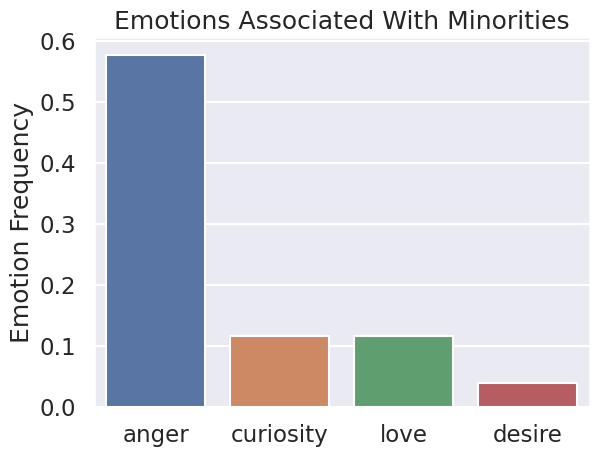

In [30]:
KeyWordSearchTerm = "Minorities" #@param {type:"string"}
max_count = 4

matches = df[(df['Emotion'] != "neutral") & df['Contents'].str.contains(KeyWordSearchTerm, case=False)]
num_matches = len(matches.index)
print(f'{num_matches} matches')
if num_matches > 0:
  emotion_counts = matches['Emotion'].value_counts()
  emotion_counts = emotion_counts / emotion_counts.sum()
  num_emotions = len(emotion_counts.index)
  if num_emotions > max_count:
    emotion_counts = emotion_counts.nlargest(max_count)
  ax = sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
  ax.set(title=f'Emotions Associated With {KeyWordSearchTerm}', ylabel='Emotion Frequency')

# Sentiment Analysis Inference

The information GoEmotions gives is very fine-grained with 27 different emotions, but it is not that accurate. Instead of 27 emotions, sentiment analysis uses 3 categories - "positive", "negative", and "neutral" which is much more accurate and easier to visualize.

You can either reuse the results from GoEmotions for fast results, or use a different, more specialized model for more accurate results. The latter should not take nearly as long to compute as GoEmotions did. Use the checkbox under here to pick which one you want to use (unchecked = fast)

In [31]:
UseDifferentModelForSentimentAnalysis = True #@param {type:"boolean"}

In [32]:
# @title Inference

def computeSentimentUsingAccurateModel():
  import torch
  from transformers import pipeline
  
  torch.cuda.empty_cache()

  sentiment_pipeline = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment", device=0)
  tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512 // 4}
  res = sentiment_pipeline(df['Contents'].to_list(), **tokenizer_kwargs)
  label_map = {"LABEL_0": "negative", "LABEL_1":"neutral", "LABEL_2": "positive"}
  res = [label_map[x["label"]] for x in res]
  df['Sentiment'] = res

def convertGoEmotionsResultsToSentiment():
  sentiment_mapping = {
    "positive": ["amusement", "excitement", "joy", "love", "desire", "optimism", "caring", "pride", "admiration", "gratitude", "relief", "approval"],
    "negative": ["fear", "nervousness", "remorse", "embarrassment", "disappointment", "sadness", "grief", "disgust", "anger", "annoyance", "disapproval"],
    "neutral": ["realization", "surprise", "curiosity", "confusion", "neutral"]
  }
  sentiment_mapping = {v: k for k, V in sentiment_mapping.items() for v in V}

  df['Sentiment'] = df['Emotion'].map(sentiment_mapping)


if UseDifferentModelForSentimentAnalysis:
  computeSentimentUsingAccurateModel()
else:
  convertGoEmotionsResultsToSentiment()

# Sentiment Analysis Visualization

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def sentiment_table_to_positivity(df):
  counts = df[df["Sentiment"] != "neutral"]["Sentiment"].value_counts()
  percentages = 100 * counts / counts.sum()
  pos = percentages.get("positive", default=0)
  return pos

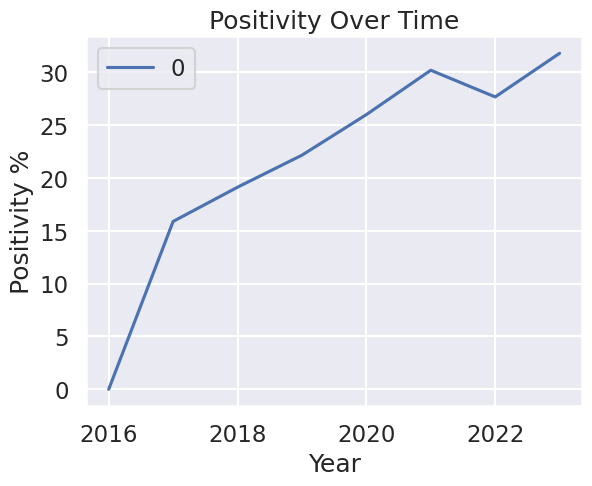

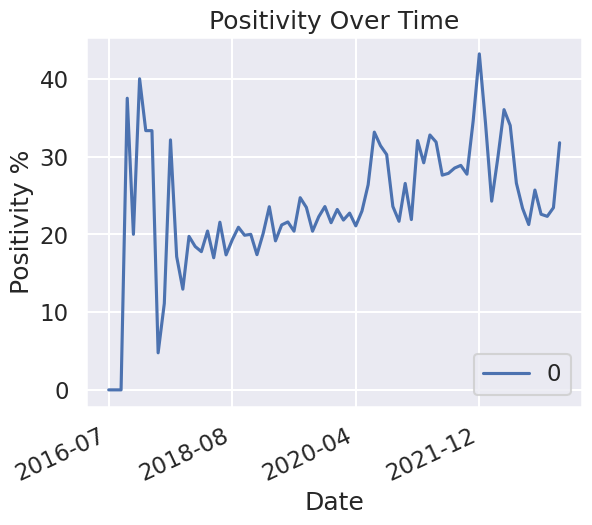

In [34]:
# @title Positivity Over Time
sentiment_over_time_by_year = group_and_transform_data(df, pd.Series(df['Timestamp'].dt.year), sentiment_table_to_positivity)
ax = sentiment_over_time_by_year.plot()
ax.set(title="Positivity Over Time", xlabel="Year", ylabel="Positivity %");

sentiment_over_time_by_month = group_and_transform_data(df, pd.Series(df['Timestamp'].dt.strftime("%Y-%m")), sentiment_table_to_positivity)
ax = sentiment_over_time_by_month.plot()
ax.set(title="Positivity Over Time", xlabel="Date", ylabel="Positivity %");
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=25, horizontalalignment='right')

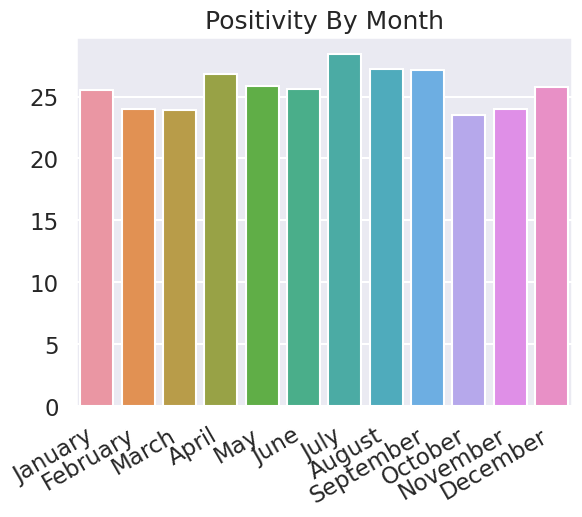

In [35]:
# @title Positivity vs Month of Year

sentiment_by_month = group_and_transform_data(df, pd.Series(df['Timestamp'].dt.month), sentiment_table_to_positivity)
month_ax = sns.barplot(x=sentiment_by_month.index, y=[e[0] for e in sentiment_by_month.values])
month_ax.set(title="Positivity By Month")
month_ax.xaxis.set_major_formatter(month_name_formatter(-1))
for label in month_ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

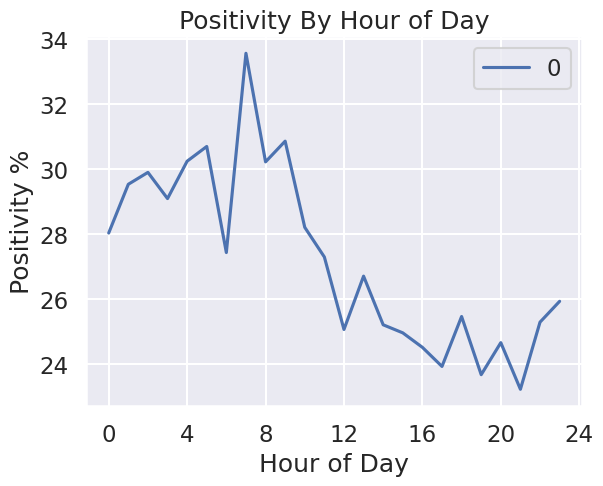

In [36]:
# @title Positivity vs Hour of Day
sentiment_by_hour = group_and_transform_data(df, pd.Series(df['Timestamp'].dt.hour), sentiment_table_to_positivity)
ax = sentiment_by_hour.plot()
ax.set(title="Positivity By Hour of Day", xlabel="Hour of Day", ylabel="Positivity %");
ax.set_xticks(range(0, 25, 4));

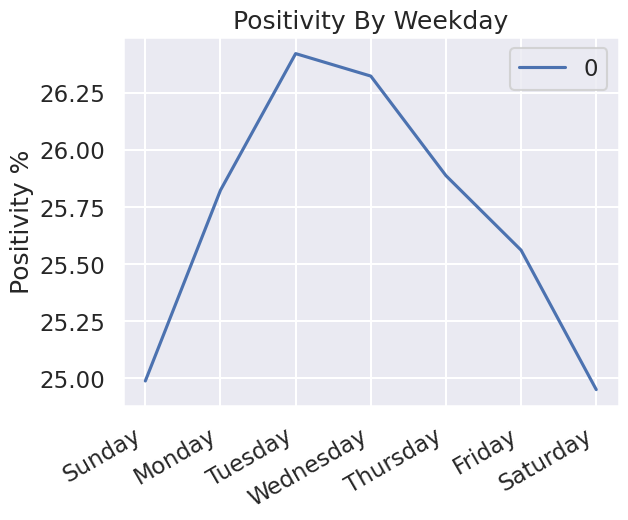

In [37]:
# @title Overall Positivity By Weekday
sentiment_by_day_of_week = group_and_transform_data(df, pd.Series(df['Timestamp'].dt.weekday), sentiment_table_to_positivity)
week_ax = sentiment_by_day_of_week.plot(kind='line', ylabel="Positivity %")
week_ax.set(title="Positivity By Weekday")
week_ax.xaxis.set_major_formatter(day_of_week_formatter)
for label in week_ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

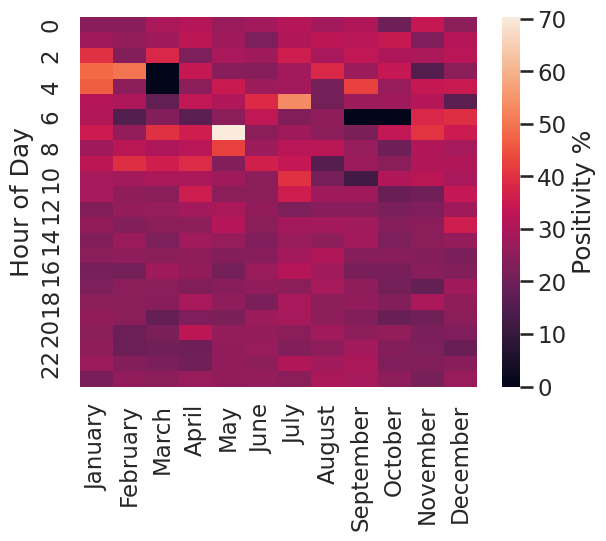

In [38]:
# @title Positivity Heatmap By Hour vs Month

def get_positivity_for_month_by_hour(df, m):
  filtered_rows = df[df['Timestamp'].dt.month == m]
  return group_and_transform_data(filtered_rows, filtered_rows['Timestamp'].dt.hour, sentiment_table_to_positivity).to_numpy()[:, 0]

month_vs_hour_count = {
    calendar.month_name[m]: get_positivity_for_month_by_hour(df, m) for m in range(1, 13)
}
month_vs_hour_count = pd.DataFrame(month_vs_hour_count)
ax = sns.heatmap(data=month_vs_hour_count, cbar_kws={'label': 'Positivity %'});
ax.set(ylabel="Hour of Day");

/tmp/ipykernel_725648/2316662173.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_rows = df[df['Contents'].str.contains(keyword, case=False)]


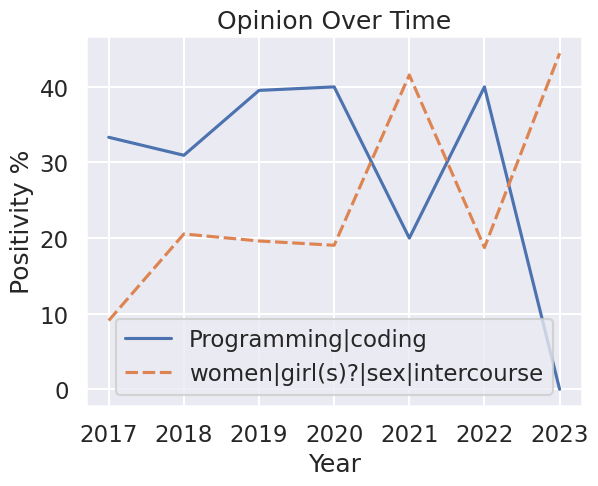

In [39]:
# @title Compare positivity over time between search terms

CommaSeparatedKeywords = "Programming|coding, women|girl(s)?|sex|intercourse" #@param {type:"string"}
MakeAnonymous = False #@param {type:"boolean"}
Granularity = "Yearly" #@param ["Monthly", "Yearly"]

keywords = [k.strip() for k in CommaSeparatedKeywords.split(r",")]
keywords_regex = [keyword_match_wrapper(k) for k in keywords]

def get_positivity_score_timeseries(df, keyword):
  filtered_rows = df[df['Contents'].str.contains(keyword, case=False)]
  disc = filtered_rows['Timestamp'].dt.strftime("%Y-%m") if Granularity == "Monthly" else filtered_rows['Timestamp'].dt.year
  sentiment_over_time = group_and_transform_data(filtered_rows, disc, sentiment_table_to_positivity)
  return sentiment_over_time

keyword_sentiments = { keyword: get_positivity_score_timeseries(df, keyword) for keyword in keywords_regex}
labels = keywords

if MakeAnonymous:
  labels = ["Person " + str(i + 1) for i in range(len(labels))]

keyword_sentiments = pd.concat(keyword_sentiments.values(), keys=labels, axis=1)
keyword_sentiments.sort_index(inplace=True)
ax = sns.lineplot(data=keyword_sentiments)
ax.set(title="Opinion Over Time", xlabel="Year", ylabel="Positivity %");

if Granularity == "Monthly":
  ax.set_xticks([v if i % 10 == 0 else "" for i, v in enumerate(keyword_sentiments.index)]);
else:
  ax.set_xticks(keyword_sentiments.index)